
# Oceandrift backtracking


In [1]:
import os
os.path

from datetime import datetime, timedelta
import cmocean

import pyproj
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import trajan as ta

import opendrift
from opendrift.models.oceandrift import OceanDrift
from opendrift.readers import reader_netCDF_CF_generic
from opendrift.models.physics_methods import wind_drift_factor_from_trajectory, distance_between_trajectories, skillscore_liu_weissberg

import cartopy.crs as ccrs
from matplotlib.lines import Line2D

from scipy.spatial import ConvexHull, convex_hull_plot_2d

In [2]:
def reproject(latitude, longitude):
    """Returns the x & y coordinates in meters using a sinusoidal projection"""
    from math import pi, cos, radians
    earth_radius = 6371009 # in meters
    lat_dist = pi * earth_radius / 180.0

    y = [lat * lat_dist for lat in latitude]
    x = [long * lat_dist * cos(radians(lat)) 
                for lat, long in zip(latitude, longitude)]
    return x, y

def area_of_polygon(x, y):
    """Calculates the area of an arbitrary polygon given its verticies"""
    area = 0.0
    for i in range(-1, len(x)-1):
        area += x[i] * (y[i+1] - y[i-1])
    return abs(area) / 2.0

def polygon_centroid(xs, ys):
    """https://en.wikipedia.org/wiki/Centroid#Of_a_polygon"""
    xy = np.array([xs, ys])
    c = np.dot(xy + np.roll(xy, 1, axis=1),
               xs * np.roll(ys, 1) - np.roll(xs, 1) * ys
               ) / (6 * area_of_polygon(xs, ys))
    return c

def mean_point(x, y):
    centroid = (sum(x) / len(x), sum(y) / len(y))
    return centroid

### Import Agulhas drifter trajectory data

In [3]:
d10 = xr.open_dataset('C:/Users/bente/Documents/THESIS/OO-2023/OO-2023.nc')       # all drifter data
d10 = d10.traj.gridtime('1H')
d10 = d10.isel(trajectory=6)             # drifter OO-2023-03

In [4]:
start_date = datetime(2023,1,9,11,12,8)  # first day of deployment/you want to run from 
end_date = datetime(2023,3,8,23,12,8)   # first day of last simulation
time_delta = timedelta(days=0.5)         # 12h
duration = timedelta(hours=48)           # 2 days

start_time = [] 
end_time = []

while (start_date <= end_date):
    start_date += time_delta
    start_time.append(start_date)
    end_time.append(start_date + duration)

In [5]:
month = np.array([1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,3])          #range of months to run over
days = np.array([9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,1,2,3,4,5,6,7,8,9,10,11])          #range of days of the month to run over

startlat = []
startlon = [] 
for i in range(59):
    startlat.append([d10.lat.sel(time=slice(datetime(2023, month[i], days[i], 11, 12, 8), datetime(2023, month[i], days[i], 11, 12, 8))).values])
    startlat.append([d10.lat.sel(time=slice(datetime(2023, month[i], days[i], 23, 12, 8), datetime(2023, month[i], days[i], 23, 12, 8))).values])
    startlon.append([d10.lon.sel(time=slice(datetime(2023, month[i], days[i], 11, 12, 8), datetime(2023, month[i], days[i], 11, 12, 8))).values])
    startlon.append([d10.lon.sel(time=slice(datetime(2023, month[i], days[i], 23, 12, 8), datetime(2023, month[i], days[i], 23, 12, 8))).values])

ilat = []
ilon = [] 
for i in range(59):
    ilat.append([d10.lat.sel(time=slice(datetime(2023, month[i+2], days[i+2], 11, 12, 8), datetime(2023, month[i+2], days[i+2], 11, 12, 8))).values])
    ilat.append([d10.lat.sel(time=slice(datetime(2023, month[i+2], days[i+2], 23, 12, 8), datetime(2023, month[i+2], days[i+2], 23, 12, 8))).values])
    ilon.append([d10.lon.sel(time=slice(datetime(2023, month[i+2], days[i+2], 11, 12, 8), datetime(2023, month[i+2], days[i+2], 11, 12, 8))).values])
    ilon.append([d10.lon.sel(time=slice(datetime(2023, month[i+2], days[i+2], 23, 12, 8), datetime(2023, month[i+2], days[i+2], 23, 12, 8))).values])

We try to find the likelihood of the origin of a found object by two different methods:
1. forwards simulation from a uniform grid of possible initial locations, selecting the origins of particles actually hitting the observed target (='hits'). Number of 'hits' is N.
2. backwards simulation from position where object is found ('Observation') of N particles

We use 48 hour segments along the observed drifter trajectories of the OpenMetBuoy-2021 with the Globcurrent ocean product to run the Oceandrift model (no wind and/or Stokes).


### FORWARD

Simulating forward, starting at a uniform grid 48 hours earlier (440 x 320 = 140800 elements at ~500m separation)


In [6]:
len(startlon)

118

In [7]:
reader_globcur = reader_netCDF_CF_generic.Reader("C:/Users/bente/Documents/THESIS/Globcurrent/*.nc")

# Define domain of possible origin
lons = []
lats = []
for i in range(117):
    lons.append(np.arange(np.array(startlon[i])-0.5, np.array(startlon[i])+0.75, .1/2)) # Much coarser CCC
    lats.append(np.arange(np.array(startlat[i])-0.85, np.array(startlat[i])+0.6, .05/2))
    lons[i], lats[i] = np.meshgrid(lons[i], lats[i])

In [8]:
outfile = []
for i in range(117):
    outfile.append("D:/backtrack/oceandrift_48h/fwd_loop_dr10_"+str(i)+".nc")

In [10]:
for i in range(117):
    ofwd = OceanDrift(loglevel=50)
    ofwd.add_reader([reader_globcur])
    ofwd.seed_elements(lon=lons[i], lat=lats[i], radius=0, time=start_time[i])
    ofwd.run(duration=duration, time_step=900, time_step_output=3600, outfile=outfile[i])

Finding the elements actually hitting the target (within 5 km) after 48 hours:

In [9]:
sims = []
for f in outfile: 
    sims.append(xr.open_dataset(f))    

1. How many hits (n)
2. Area of convex hull 
3. Seperartion distance of centre of gravity convex hull to initial location observed drifter 

In [10]:
############ KIND OF WORKING --> !!! SEE ERROR !!! #############


n = []
msd_hits = []
sepdis_fwd = []

for i in range(117): 
    lon = []
    lat = []
    lonend = []
    latend = []
    for j in range(len(sims[i].trajectory)):
        ### calculating hits ###
        lon.append(sims[i].isel(trajectory=j).lon.values)
        lat.append(sims[i].isel(trajectory=j).lat.values)
        lonend.append(sims[i].isel(trajectory=j).lon.values[-1])   # lon at end of trajectory
        latend.append(sims[i].isel(trajectory=j).lat.values[-1])   # lat at end of trajectory
    
    geod = pyproj.Geod(ellps='WGS84')
    on = np.ones(len(lonend))
    dummy1, dummy2, dist2incident = geod.inv(lonend, latend, ilon[i]*on, ilat[i]*on)
    hits = np.where(dist2incident<5000)[1]
    lenhits = len(hits)
    if lenhits>0:
        n.append(lenhits)             # How many hits per 48h segment simulations 
    else:
        n.append(np.nan)

    hit_start_lons = []
    hit_start_lats = []
    for m in range(len(hits)):
        hit_start_lons.append(lon[hits[m]][0])
        hit_start_lats.append(lat[hits[m]][0])
        
    ### calculating sep. dist. point of gravity of hits to drifter obs. location ###
    if len(hit_start_lons)>1: 
        centroid_fwd = mean_point(hit_start_lons, hit_start_lats)
        sepdis_fwd.append(ta.skill.distance_between_trajectories(startlon[i], startlat[i], np.array([centroid_fwd[0]]), np.array([centroid_fwd[1]])))   
        sd_hits = []
        for l in range(len(hits)):    
            sd_hits.append(ta.skill.distance_between_trajectories(np.array([hit_start_lons[l]]), np.array([hit_start_lats[l]]), np.array([centroid_fwd[0]]), np.array([centroid_fwd[1]])))
        msd_hits.append(np.mean(sd_hits))
    else:
        sepdis_fwd.append(np.nan)
        msd_hits.append(np.nan)

### BACKWARD

In [11]:
outfile_back = []
for i in range(117):
    outfile_back.append("D:/backtrack/oceandrift_48h/back_loop_dr10_"+str(i)+".nc")

Simulating backwards for 48 hours:

In [12]:
for i in range(117):
    orev = OceanDrift(loglevel=50)
    orev.add_reader([reader_globcur])
    if n[i]>0:
        orev.seed_elements(lon=ilon[i], lat=ilat[i], radius=5000, radius_type='uniform', number=n[i],
                         time=end_time[i])
        orev.run(duration=duration, time_step=-900, time_step_output=3600, outfile=outfile_back[i])
#         sims_back.append(xr.open_dataset(outfile_back[i]))    
#     else: 
#         sims_back.append(np.nan)

KeyboardInterrupt: 

Open files WITHOUT running it again.... 

In [13]:
sims_back = []
for i in range(117):
    if n[i]>0:
        sims_back.append(xr.open_dataset(outfile_back[i]))     # For the forward runs with hits
    else: 
        sims_back.append(np.nan)                               # For the forward runs without hits

Calculating the area of the convex hull and seperation distance between point of gravity of convex hull and observed driter position at the start of the time segment/trajectory

In [14]:
msd_hits_back = []
sepdis_back = []

for i in range(len(sims_back)): 
    if sims_back[i]>0:
        lon = []
        lat = []
        lonend = []
        latend = []
        for j in range(len(sims_back[i].trajectory)):
            lon.append(sims_back[i].isel(trajectory=j).lon.values)
            lat.append(sims_back[i].isel(trajectory=j).lat.values)
            lonend.append(sims_back[i].isel(trajectory=j).lon.values[-1])   # lon at end of trajectory
            latend.append(sims_back[i].isel(trajectory=j).lat.values[-1])   # lat at end of trajectory
        
        ### calculating sep. dist. point of gravity of hits to drifter obs. location ###
        if len(lonend)>1: 
            centroid_back = mean_point(lonend, latend)
            sepdis_back.append(ta.skill.distance_between_trajectories(startlon[i], startlat[i], np.array([centroid_back[0]]), np.array([centroid_back[1]])))   
            
            sd_hits = []
            for j in range(len(lonend)):
                sd_hits.append(ta.skill.distance_between_trajectories(np.array([lonend[j]]), np.array([latend[j]]), np.array([centroid_back[0]]), np.array([centroid_back[1]])))
            msd_hits_back.append(np.mean(sd_hits))
        else:
            sepdis_fwd.append(np.nan)
            msd_hits_back.append(np.nan)
            
    else:
        sepdis_back.append(np.nan)
        msd_hits_back.append(np.nan)
    

## Save area and sep.dist.

In [15]:
sepdis_fwd_new = []
sepdis_back_new = []
for i in range(len(sepdis_fwd)):
    if sepdis_fwd[i] is not np.nan: 
        sepdis_fwd_new.append(sepdis_fwd[i][0])
    else: 
        sepdis_fwd_new.append(np.nan)
    if sepdis_back[i] is not np.nan: 
        sepdis_back_new.append(sepdis_back[i][0])
    else: 
        sepdis_back_new.append(np.nan)

IndexError: list index out of range

In [16]:
# np.savetxt('area_forward10.out', area_forward, delimiter=',')
# np.savetxt('sepdis_fwd10.out', sepdis_fwd_new, delimiter=',')
# np.savetxt('area_back10.out', area_back, delimiter=',')
# np.savetxt('sepdis_back10.out', sepdis_back_new, delimiter=',')
# np.savetxt('n10.out', n, delimiter=',')
np.savetxt('msd_fwd10.out', msd_hits, delimiter=',')
np.savetxt('msd_back10.out', msd_hits_back, delimiter=',')

## Compare forward and backward runs

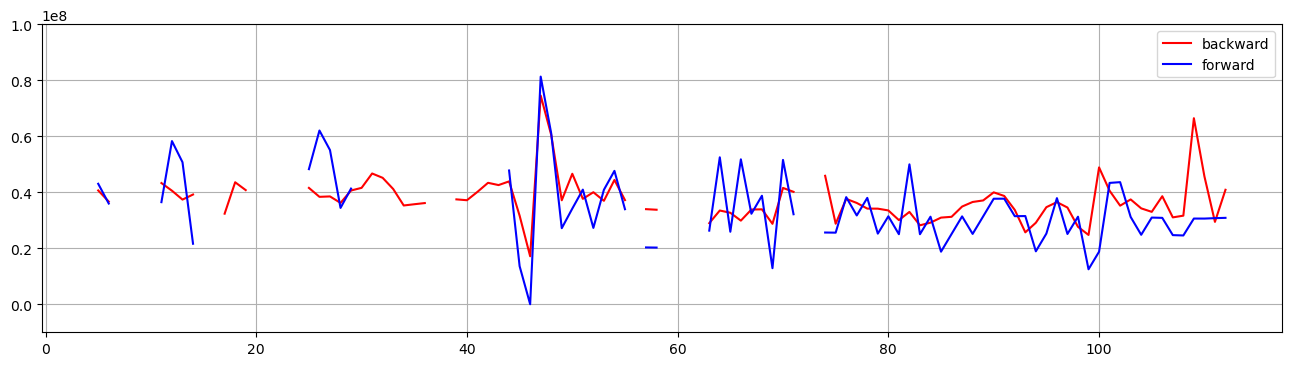

In [27]:
plt.figure(figsize=(16,4))
plt.plot(area_back, color='red', linestyle='-', label='backward')
plt.plot(area_forward, color='blue', linestyle='-', label='forward')

plt.ylim([-10000000,1e8])
plt.legend()
plt.grid()

Forward runs: more often NaN because then all the 'hits' were on the same lon or same lat. This makes it impossible to calculate the convex hull area, as it is a line and not a polygon. 
1.  Maybe want to change this!
2.  Target area now 5000m from observed drifter (so radius of 10km): quite often no hits: MAYBE CHANGE TO LARGER TARGET AREA

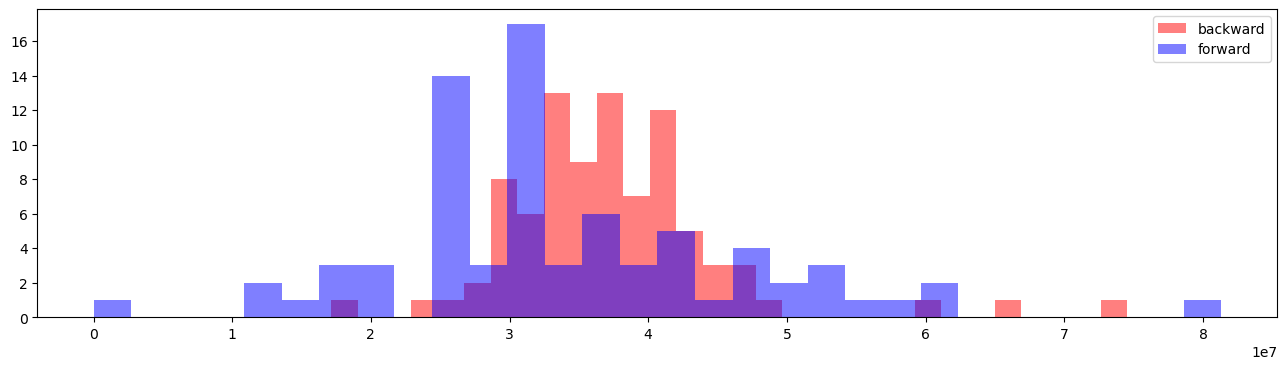

In [28]:
plt.figure(figsize=(16,4))
plt.hist(area_back, bins=30, color='red', label='backward', alpha=0.5)
plt.hist(area_forward, bins=30, color='blue', label='forward', alpha=0.5)
plt.legend()

Text(0, 0.5, 'Area convex hull')

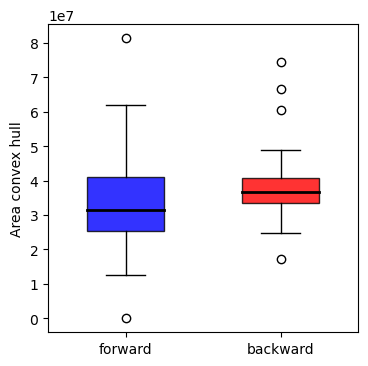

In [29]:
area_back_nan = np.array(area_back)[~np.isnan(np.array(area_back))]
area_forward_nan = np.array(area_forward)[~np.isnan(np.array(area_forward))]

plt.figure(figsize=(4,4))
plt.boxplot(area_back_nan, positions=[2], patch_artist=True, boxprops=dict(facecolor='red', alpha=0.8), medianprops=dict(color='black', linewidth=2), widths = 0.5)
plt.boxplot(area_forward_nan, positions=[1], patch_artist=True, boxprops=dict(facecolor='blue', alpha=0.8), medianprops=dict(color='black', linewidth=2), widths = 0.5)
plt.xticks([1,2],['forward', 'backward'])
plt.ylabel('Area convex hull')

Text(0, 0.5, 'msd centroid')

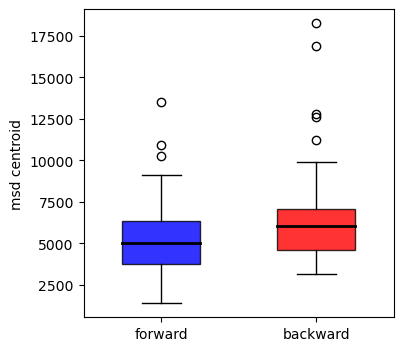

In [17]:
msd_back_nan = np.array(msd_hits_back)[~np.isnan(np.array(msd_hits_back))]
msd_forward_nan = np.array(msd_hits)[~np.isnan(np.array(msd_hits))]

plt.figure(figsize=(4,4))
plt.boxplot(msd_back_nan, positions=[2], patch_artist=True, boxprops=dict(facecolor='red', alpha=0.8), medianprops=dict(color='black', linewidth=2), widths = 0.5)
plt.boxplot(msd_forward_nan, positions=[1], patch_artist=True, boxprops=dict(facecolor='blue', alpha=0.8), medianprops=dict(color='black', linewidth=2), widths = 0.5)
plt.xticks([1,2],['forward', 'backward'])
plt.ylabel('msd centroid')

In [30]:
dif = []
for i in range(len(area_forward)):
    dif.append(area_back[i]-area_forward[i])

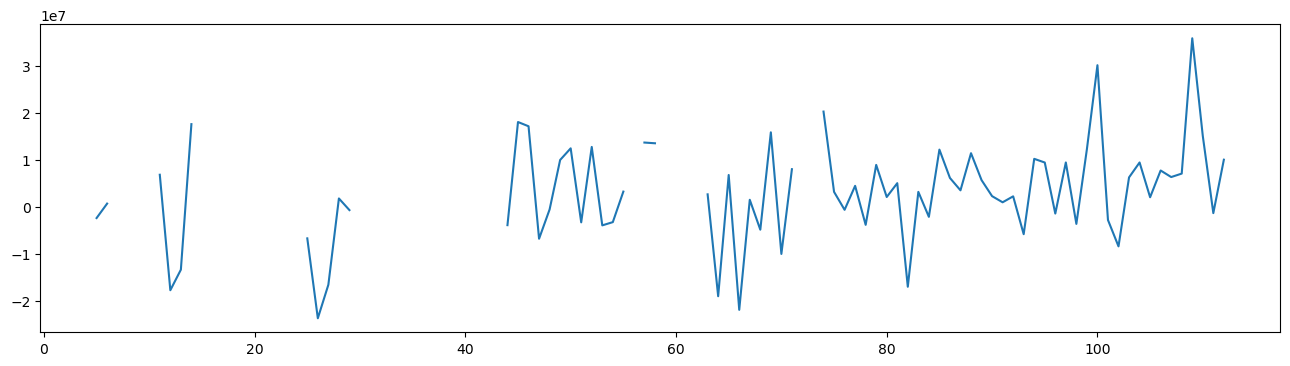

In [31]:
plt.figure(figsize=(16,4))
plt.plot(dif)

### seperation distance

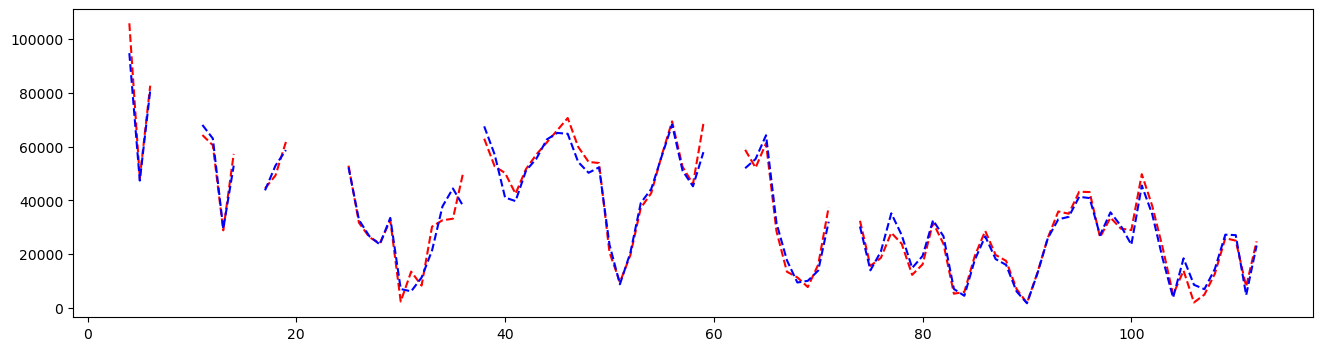

In [35]:
plt.figure(figsize=(16,4))
plt.plot(sepdis_back_new, color='red', linestyle='--')
plt.plot(sepdis_fwd_new, color='blue', linestyle='--')


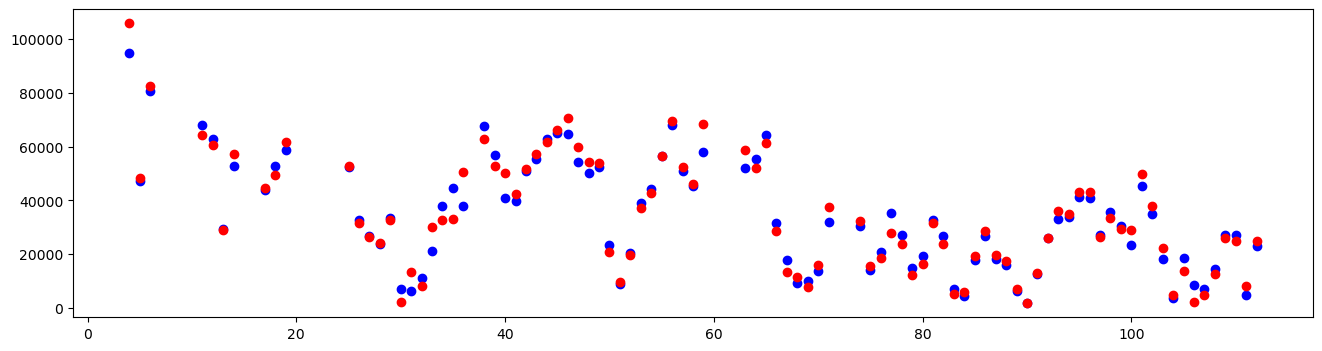

In [36]:
plt.figure(figsize=(16,4))
plt.scatter(range(len(sepdis_fwd_new)),sepdis_fwd_new, color='blue')
plt.scatter(range(len(sepdis_back_new)),sepdis_back_new, color='red')

(-10000.0, 10000.0)

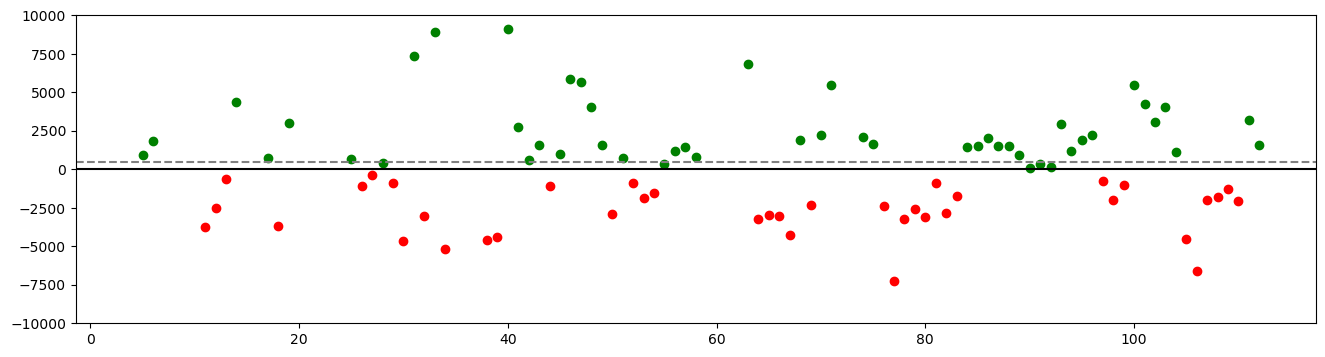

In [40]:
dif = np.array(sepdis_back_new) - np.array(sepdis_fwd_new)
ldif = range(len(dif))
meandif = np.nanmean(dif)

plt.figure(figsize=(16,4))
for i in range(len(dif)):
    if dif[i]>0:
        plt.scatter(ldif[i], dif[i], color='green')
    else:
        plt.scatter(ldif[i], dif[i], color='red')

plt.axhline(y=0, color='black')
plt.axhline(meandif, color='grey', linestyle='--')
plt.ylim([-10000, 10000])

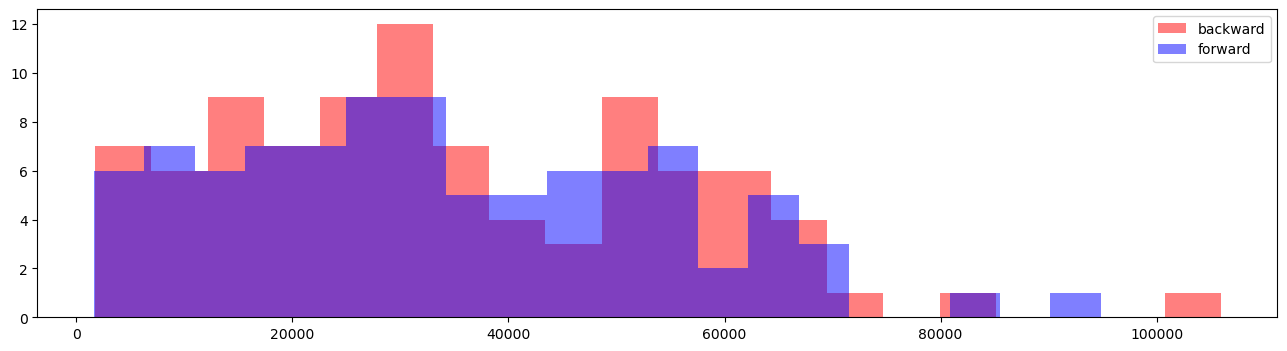

In [41]:
plt.figure(figsize=(16,4))
plt.hist(sepdis_back_new, bins=20, color='red', label='backward', alpha=0.5)
plt.hist(sepdis_fwd_new, bins=20, color='blue', label='forward', alpha=0.5)
plt.legend()

Text(0, 0.5, 'Sep. dist.')

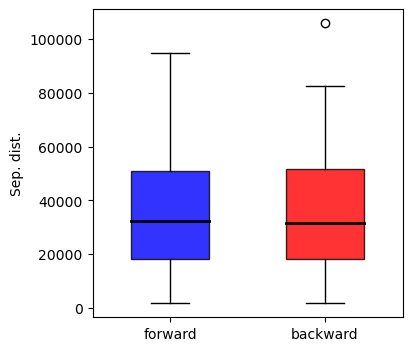

In [42]:
sepdis_back_new_nan = np.array(sepdis_back_new)[~np.isnan(np.array(sepdis_back_new))]
sepdis_fwd_new_nan = np.array(sepdis_fwd_new)[~np.isnan(np.array(sepdis_fwd_new))]

plt.figure(figsize=(4,4))
plt.boxplot(sepdis_back_new_nan, positions=[2], patch_artist=True, boxprops=dict(facecolor='red', alpha=0.8), medianprops=dict(color='black', linewidth=2), widths = 0.5)
plt.boxplot(sepdis_fwd_new_nan, positions=[1], patch_artist=True, boxprops=dict(facecolor='blue', alpha=0.8), medianprops=dict(color='black', linewidth=2), widths = 0.5)
plt.xticks([1,2],['forward', 'backward'])
plt.ylabel('Sep. dist.')

### number of hits

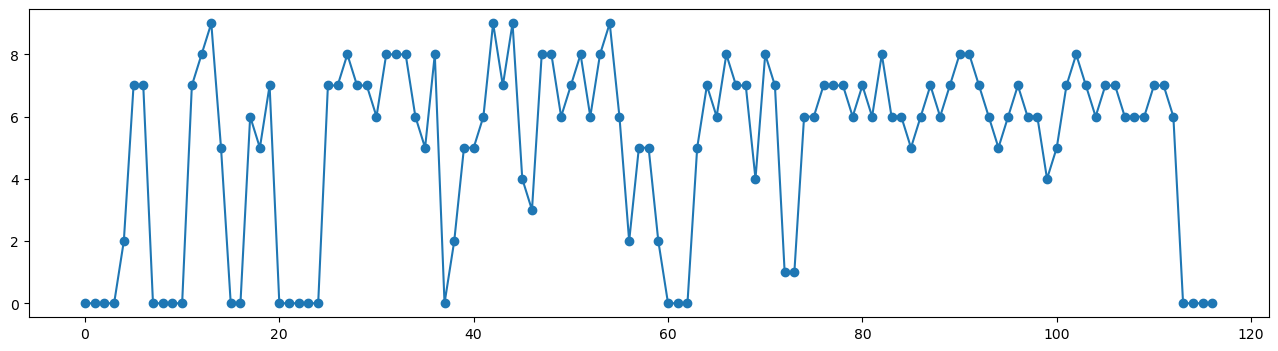

In [43]:
plt.figure(figsize=(16,4))
plt.scatter(range(117),n)
plt.plot(n)